# Start with RIS

In [722]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error


h = pd.read_csv('../data/holidays.csv')

# create a pandas dataframe object
df = pd.read_csv('../data/RIS_aht_vol.csv', index_col=0,
                 parse_dates=['date'])

# create column for aht
df['aht'] = df['handle_time']/df['volume_handled']
df['aht_forecast'] = df['handle_time_forecast']/df['volume_forecast']
df['workload'] = df['handle_time'] / 3600

df.index = df['date']
display(df.head())

df1 = df.copy()

,date,handle_time,handle_time_forecast,volume,volume_forecast,volume_handled,aht,aht_forecast,workload
date,,,,,,,,,
2016-01-01,2016-01-01,2006.0,NaN,6.0,0.0,6.0,334.333333,NaN,0.557222
2016-01-02,2016-01-02,728895.0,NaN,1174.0,921.0,1167.0,624.588689,NaN,202.470833
2016-01-03,2016-01-03,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.000000
2016-01-04,2016-01-04,3996279.0,NaN,6886.0,6547.0,6046.0,660.978994,NaN,1110.077500
2016-01-05,2016-01-05,3175414.0,NaN,4928.0,4328.0,4715.0,673.470626,NaN,882.059444


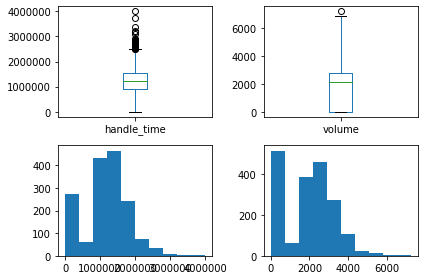

In [723]:
plt.subplot(221)
df['handle_time'].plot.box()

plt.subplot(222)
df['volume'].plot.box()

plt.subplot(223)
df['handle_time'].hist(grid=False)

plt.subplot(224)
df['volume'].hist(grid=False)
plt.tight_layout()
plt.show()

# Date Range

In [724]:
print('Start:', df['date'].min())
print('End:', df['date'].max())

df['month'] = df['date'].dt.month_name()
df['year'] = df['date'].dt.year

Start: 2016-01-01 00:00:00
End: 2021-01-28 00:00:00


# Holidays and weekends

In [725]:
df['date'].dt.weekday.isin([5,6]).any(),df['date'].isin(h.iloc[:,0].tolist()).any()

(True, True)

In [726]:
df = df[(~df['date'].dt.weekday.isin([5,6]))  & (~df['date'].isin(h.iloc[:,0].tolist()))]

# Check holidays and weekends are removed from training data

In [727]:
df['date'].dt.weekday.isin([5,6]).any(),df['date'].isin(h.iloc[:,0].tolist()).any()

(False, False)

In [728]:
df.isna().sum()

date                       0
handle_time                0
handle_time_forecast    1119
volume                     0
volume_forecast            0
volume_handled             0
aht                        5
aht_forecast            1119
workload                   0
month                      0
year                       0
dtype: int64

# days of null aht are due to zero handle time and volume

In [729]:
display(df[df['handle_time'] < 100000])

,date,handle_time,handle_time_forecast,volume,volume_forecast,volume_handled,aht,aht_forecast,workload,month,year
date,,,,,,,,,,,
2016-01-01,2016-01-01,2006.0,NaN,6.0,0.0,6.0,334.333333,NaN,0.557222,January,2016
2016-05-30,2016-05-30,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.000000,May,2016
2016-07-04,2016-07-04,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.000000,July,2016
2016-09-05,2016-09-05,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.000000,September,2016
2016-11-24,2016-11-24,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.000000,November,2016
2016-12-26,2016-12-26,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.000000,December,2016


In [730]:
# (df[df['aht'].isna()]['date'] == df[df['handle_time'] < 100000]['date']).all()

In [731]:
null_dates = df[df['aht'].isna()]['date'].tolist()

# Remove these dates

In [732]:
df = df[~df['date'].isin(null_dates)]

# Analyze volume

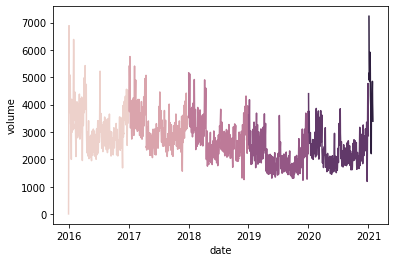

In [733]:
ax = sns.lineplot(x='date', y='volume', hue='year', data=df)
ax.get_legend().remove()
plt.show()

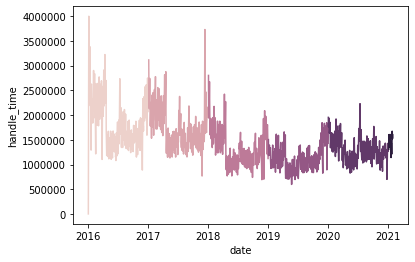

In [734]:
ax = sns.lineplot(x='date', y='handle_time', hue='year', data=df)
ax.get_legend().remove()
plt.show()

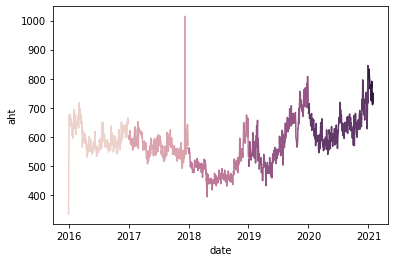

In [735]:
ax = sns.lineplot(x='date', y='aht', hue='year', data=df)
ax.get_legend().remove()
plt.show()

# What are these outlier low points?

In [736]:
df = df[(df['aht'] > 400) | (df['aht'] < 900) | (df['handle_time'] > 500000)]

In [737]:
# optional filter
# df = df[df['handle_time'] > 2000000]

In [738]:
df['abandonment_rate'] = (df['volume'] - df['volume_handled'])/df['volume']

In [739]:
df[['volume', 'workload', 'aht']].describe()

,volume,workload,aht
count,1283.000000,1283.000000,1283.000000
mean,2638.696804,392.002466,578.993060
std,809.874128,123.825617,75.607259
min,6.000000,0.557222,334.333333
25%,2066.500000,305.410278,532.000000
50%,2511.000000,369.459722,577.733049
75%,3101.500000,456.346250,626.127998
max,7230.000000,1110.077500,1015.029948


In [740]:
df[(df['date'] >= '2021-01-01') & (df['date'] < '2021-01-29')][['volume', 'workload', 'aht']].describe()

,volume,workload,aht
count,19.000000,19.000000,19.000000
mean,4549.052632,407.123099,769.056300
std,1068.349947,40.731085,34.927235
min,2208.000000,316.991389,710.254788
25%,3996.000000,384.716111,755.865776
50%,4354.000000,422.420556,768.307816
75%,5034.000000,442.309444,795.783333
max,7230.000000,464.668056,833.009865


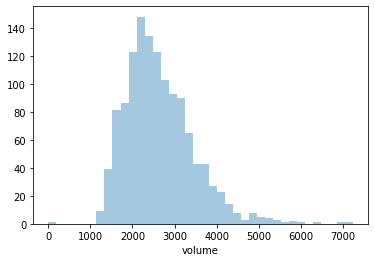

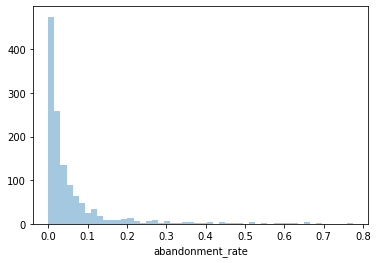

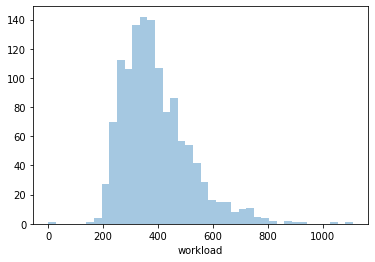

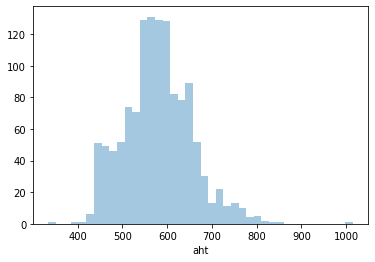

In [741]:
for k in ['volume', 'abandonment_rate', 'workload', 'aht']:
    sns.distplot(df[k], norm_hist=False, kde=False)
    plt.show()

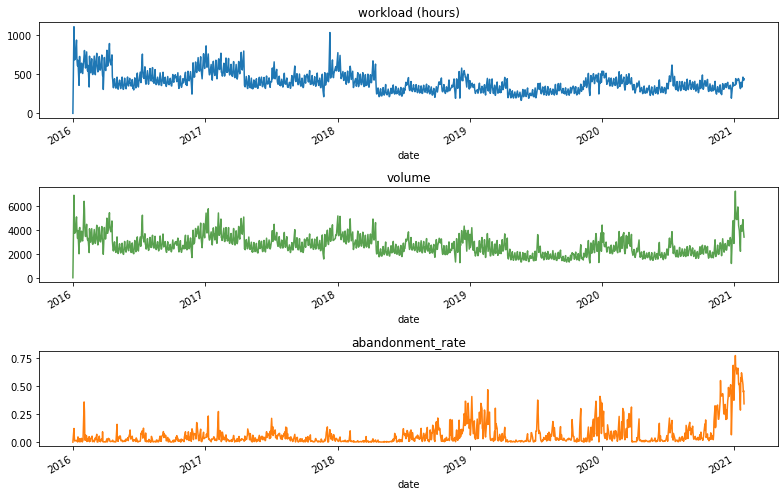

In [742]:
plt.figure(figsize=(11,7))
plt.subplot(311)
df['workload'].plot(color='#1f77b4')
plt.title('workload (hours)')
plt.subplot(312)
df['volume'].plot(color='#59a14f')
plt.title('volume')
plt.subplot(313)
df['abandonment_rate'].plot(color='#ff7f0e')
plt.title('abandonment_rate')
plt.tight_layout()
plt.show()

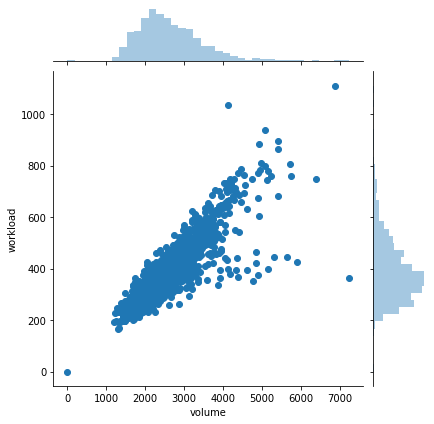

In [697]:
_ = sns.jointplot(x='volume', y='workload', data=df)

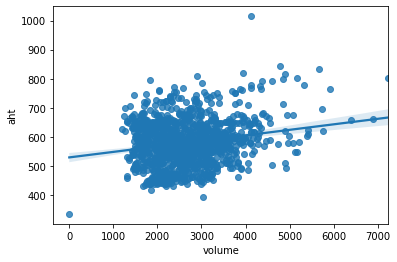

In [698]:
_ = sns.regplot(data=df,x='volume', y='aht' )

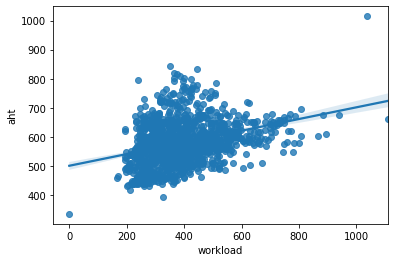

In [699]:
_ = sns.regplot(data=df,x='workload', y='aht' )

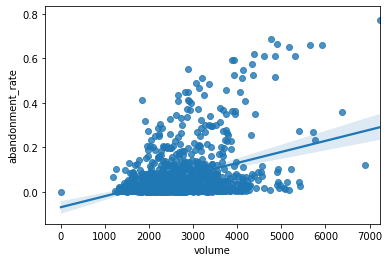

In [700]:
_ = sns.regplot(data=df,x='volume', y='abandonment_rate' )

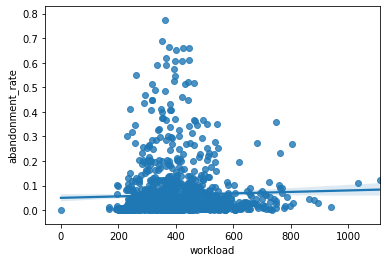

In [701]:
_ = sns.regplot(data=df,x='workload', y='abandonment_rate' )

In [702]:
# validate aht forecast is only null where handle_time_forecast is null 
(df[df['handle_time_forecast'].notnull()].index == df[df['aht_forecast'].notnull()].index).all()

True

In [703]:
df[df['aht_forecast'].notnull()].head(1)

,date,handle_time,handle_time_forecast,volume,volume_forecast,volume_handled,aht,aht_forecast,workload,month,year,abandonment_rate
date,,,,,,,,,,,,
2020-06-01,2020-06-01,1192680.0,1209802.0,2017.0,1957.0,2006.0,594.556331,618.192131,331.3,June,2020,0.005454


In [704]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1283 entries, 2016-01-01 to 2021-01-28
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1283 non-null   datetime64[ns]
 1   handle_time           1283 non-null   float64       
 2   handle_time_forecast  169 non-null    float64       
 3   volume                1283 non-null   float64       
 4   volume_forecast       1283 non-null   float64       
 5   volume_handled        1283 non-null   float64       
 6   aht                   1283 non-null   float64       
 7   aht_forecast          169 non-null    float64       
 8   workload              1283 non-null   float64       
 9   month                 1283 non-null   object        
 10  year                  1283 non-null   int64         
 11  abandonment_rate      1283 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memo

In [705]:
df.reset_index(drop=True)

,date,handle_time,handle_time_forecast,volume,volume_forecast,volume_handled,aht,aht_forecast,workload,month,year,abandonment_rate
0,2016-01-01,2006.0,NaN,6.0,0.0,6.0,334.333333,NaN,0.557222,January,2016,0.000000
1,2016-01-04,3996279.0,NaN,6886.0,6547.0,6046.0,660.978994,NaN,1110.077500,January,2016,0.121987
2,2016-01-05,3175414.0,NaN,4928.0,4328.0,4715.0,673.470626,NaN,882.059444,January,2016,0.043222
3,2016-01-06,2466037.0,NaN,3713.0,3987.0,3676.0,670.847933,NaN,685.010278,January,2016,0.009965
4,2016-01-07,2529994.0,NaN,3910.0,4006.0,3862.0,655.099430,NaN,702.776111,January,2016,0.012276
...,...,...,...,...,...,...,...,...,...,...,...,...
1278,2021-01-22,1210117.0,2696876.0,3883.0,3362.0,1583.0,764.445357,802.164188,336.143611,January,2021,0.592326
1279,2021-01-25,1672805.0,3996030.0,4851.0,4910.0,2349.0,712.134951,813.855397,464.668056,January,2021,0.515770
1280,2021-01-26,1594522.0,3589843.0,4064.0,4471.0,2245.0,710.254788,802.917244,442.922778,January,2021,0.447589
1281,2021-01-27,1523807.0,3351563.0,3755.0,4205.0,2028.0,751.384122,797.042331,423.279722,January,2021,0.459920


In [706]:
df[df['year']==2021].reset_index(drop=True)

,date,handle_time,handle_time_forecast,volume,volume_forecast,volume_handled,aht,aht_forecast,workload,month,year,abandonment_rate
0,2021-01-04,1308354.0,3339378.0,7230.0,4417.0,1634.0,800.706242,756.028526,363.431667,January,2021,0.773997
1,2021-01-05,1604377.0,2595929.0,5657.0,3471.0,1926.0,833.009865,747.890810,445.660278,January,2021,0.659537
2,2021-01-06,1349627.0,2404033.0,4899.0,3226.0,1651.0,817.460327,745.205518,374.896389,January,2021,0.662992
3,2021-01-07,1439905.0,2323631.0,5169.0,3127.0,1798.0,800.837041,743.086345,399.973611,January,2021,0.652157
4,2021-01-08,1520714.0,2340892.0,4853.0,3146.0,1900.0,800.375789,744.085188,422.420556,January,2021,0.608490
5,2021-01-11,1532409.0,4522367.0,5912.0,5462.0,2002.0,765.439061,827.969059,425.669167,January,2021,0.661367
6,2021-01-12,1607269.0,3606475.0,5319.0,4403.0,2069.0,776.833736,819.094935,446.463611,January,2021,0.611017
7,2021-01-13,1590106.0,3271216.0,4354.0,4019.0,2077.0,765.578238,813.937795,441.696111,January,2021,0.522967
8,2021-01-14,1554137.0,3141571.0,4115.0,3883.0,2001.0,776.680160,809.057687,431.704722,January,2021,0.513730
9,2021-01-15,1420329.0,3191053.0,3928.0,3959.0,1868.0,760.347430,806.025006,394.535833,January,2021,0.524440


# Step 3: Create Training Data and Fit Model for handle time
In order to train our model, we need to define a start and end date for the training data.
Typically, training should be performed with the most relevant or recent data.

In [707]:
## make a copy of original dataframe
df1 = df.copy()

In [708]:
## create new dataframe for prediction
df = df1[['handle_time']]

df = df.reset_index()

In [709]:
# Must pre-format column names
df.columns = ['ds','y']

# Define Training Period

In [710]:
# set start date of training data
df = df[(df['ds'] >= '2016-03-10') & (df['ds'] < '2021-01-01')]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1215 entries, 49 to 1263
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1215 non-null   datetime64[ns]
 1   y       1215 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.5 KB


In [711]:
# create default prophet model
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
m.fit(df)

In [712]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1575,2021-12-27
1576,2021-12-28
1577,2021-12-29
1578,2021-12-30
1579,2021-12-31


In [713]:
# get rid of holidays and weekends
future = future[(~future['ds'].isin(h.iloc[:,0].tolist())) & (~future['ds'].dt.weekday.isin([5,6]))]

In [714]:
forecast = m.predict(future)

# view only the last 5 predictions with confidence intervals 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1470,2021-12-27,1.963709e+06,1.665519e+06,2.253626e+06
1471,2021-12-28,1.717337e+06,1.417467e+06,2.012289e+06
1472,2021-12-29,1.583870e+06,1.276227e+06,1.881218e+06
1473,2021-12-30,1.519874e+06,1.229376e+06,1.800363e+06
1474,2021-12-31,1.534214e+06,1.246439e+06,1.827495e+06


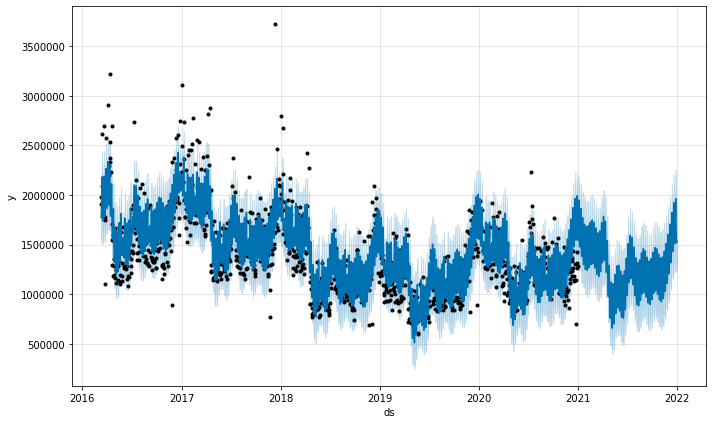

In [715]:
fig1 = m.plot(forecast)

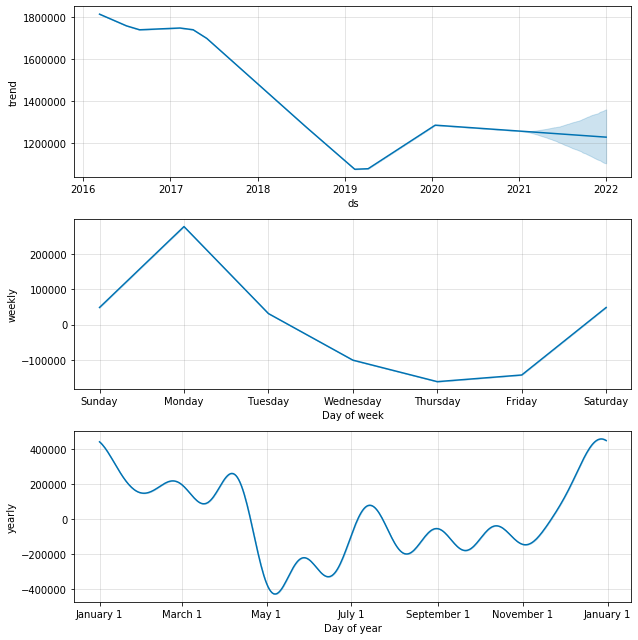

In [716]:
fig2 = m.plot_components(forecast)

# Define Validation Period

In [717]:
# set forecast beginning and end date
f = forecast.copy()
f = f[(forecast['ds'] >= '2020-06-01') & (f['ds'] < '2021-01-29')]

# create validation dataset
# set start date of validation data equal to January 1st, 2020
df2 = df1.copy()
df2 = df2[(df2['date'] >= '2020-06-01') & (df2['date'] < '2021-01-29')]

In [718]:
def validate_dates(f, df2):
    """
    take in forecast, f
    and dataframe df2 and return Bool
    """
    res = []
    # validate forecast dates shape equals actual dates shape
    v1 = df2.shape[0] == f.shape[0]
    if not v1:
        return False
    else: res.append(v1)
        
    # validate all dates for forecast equal actual dates
    res.append(all(df2['date'].dt.date.values == f['ds'].dt.date.values))
    
    return all(res)

print(validate_dates(f, df2))

True


# Score using MAE metric compared to original forecast

In [719]:
from sklearn.metrics import mean_absolute_error
def get_error(f,df2, metric):
    mae1 = mean_absolute_error(df2[metric], df2[metric + '_forecast'])
    mae2 = mean_absolute_error(df2[metric], f['yhat'])
    diff = mae1- mae2
    return pd.DataFrame(index=['old model', 'prophet', 'difference'], 
                 data=[int(mae1), int(mae2), int(diff)],
                 columns=['MAE'])/3600
    
get_error(f,df2, 'handle_time')

,MAE
old model,114.743611
prophet,47.111944
difference,67.631389


# Define methods for producing predictions and scoring

********************************************************************************
RIS_aht_vol.csv
********************************************************************************


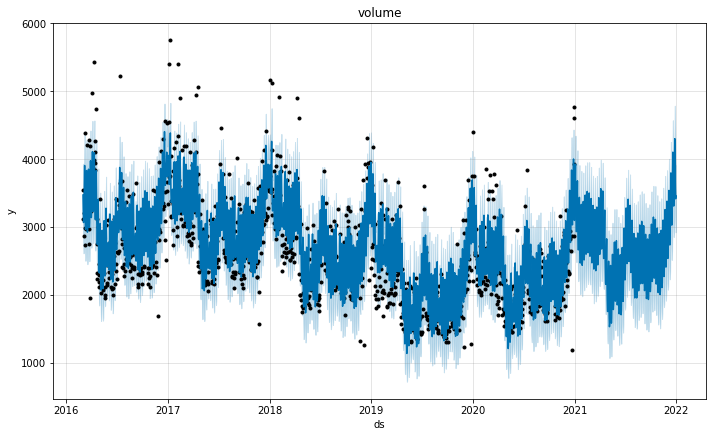

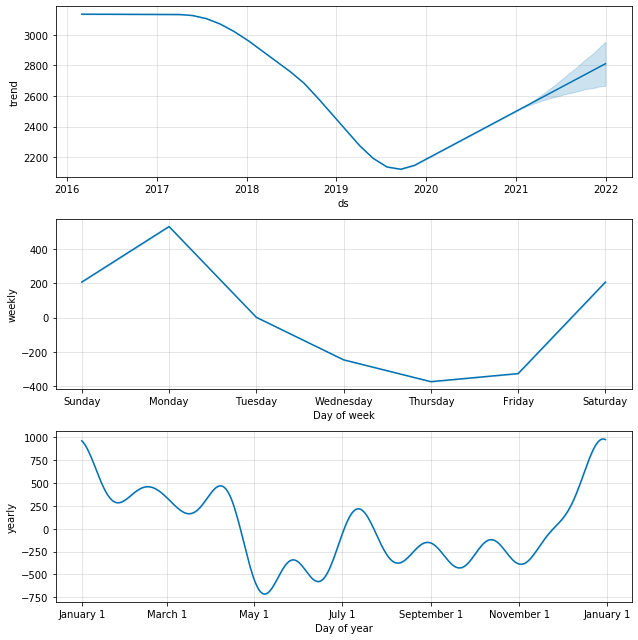

volume


,ds,yhat_lower,yhat,yhat_upper,volume,volume_forecast,error_prophet,error_forecast,diff
0,2021-01-04,3483.030671,3929.024786,4346.953649,7230.0,4417.0,3301.0,2813.0,-488.0
1,2021-01-05,2942.674787,3373.118875,3846.899359,5657.0,3471.0,2284.0,2186.0,-98.0
2,2021-01-06,2648.312949,3094.300789,3525.184213,4899.0,3226.0,1805.0,1673.0,-132.0
3,2021-01-07,2484.580420,2933.150670,3383.010836,5169.0,3127.0,2236.0,2042.0,-194.0
4,2021-01-08,2488.734837,2943.742258,3404.721409,4853.0,3146.0,1909.0,1707.0,-202.0
5,2021-01-11,3219.180079,3682.348823,4131.733555,5912.0,5462.0,2230.0,450.0,-1780.0
6,2021-01-12,2620.899887,3115.332166,3567.018796,5319.0,4403.0,2204.0,916.0,-1288.0
7,2021-01-13,2378.954523,2829.354284,3279.425498,4354.0,4019.0,1525.0,335.0,-1190.0
8,2021-01-14,2204.834978,2665.005196,3091.044705,4115.0,3883.0,1450.0,232.0,-1218.0
9,2021-01-15,2246.026460,2676.294694,3133.040669,3928.0,3959.0,1252.0,31.0,-1221.0


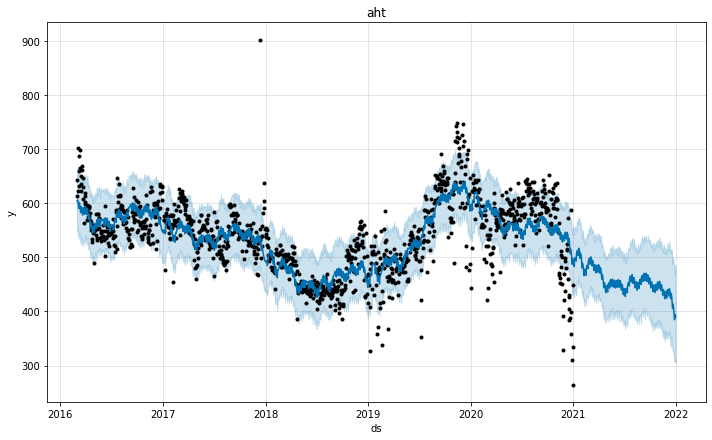

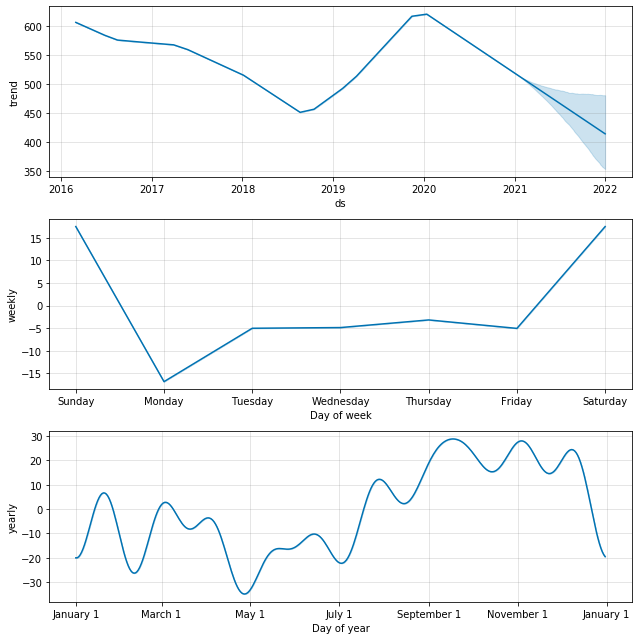

aht


,ds,yhat_lower,yhat,yhat_upper,aht,aht_forecast,error_prophet,error_forecast,diff
0,2021-01-04,426.113754,482.550840,542.237881,180.961826,756.028526,302.0,575.0,273.0
1,2021-01-05,440.944442,495.181385,550.910281,283.609157,747.890810,212.0,464.0,252.0
2,2021-01-06,437.201252,496.458001,555.633041,275.490304,745.205518,221.0,470.0,249.0
3,2021-01-07,438.852405,499.527511,555.555986,278.565487,743.086345,221.0,465.0,244.0
4,2021-01-08,439.436919,499.253566,556.518912,313.355450,744.085188,186.0,431.0,245.0
5,2021-01-11,429.783697,493.009173,547.534972,259.203146,827.969059,234.0,569.0,335.0
6,2021-01-12,451.203497,506.721367,560.189236,302.175033,819.094935,205.0,517.0,312.0
7,2021-01-13,454.938781,508.707931,564.867753,365.205788,813.937795,144.0,449.0,305.0
8,2021-01-14,451.904528,512.099447,566.841200,377.676063,809.057687,134.0,431.0,297.0
9,2021-01-15,457.392369,511.752804,567.305149,361.590886,806.025006,150.0,444.0,294.0


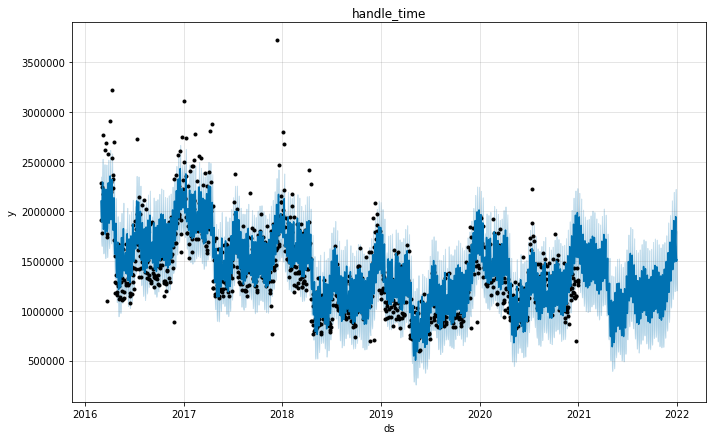

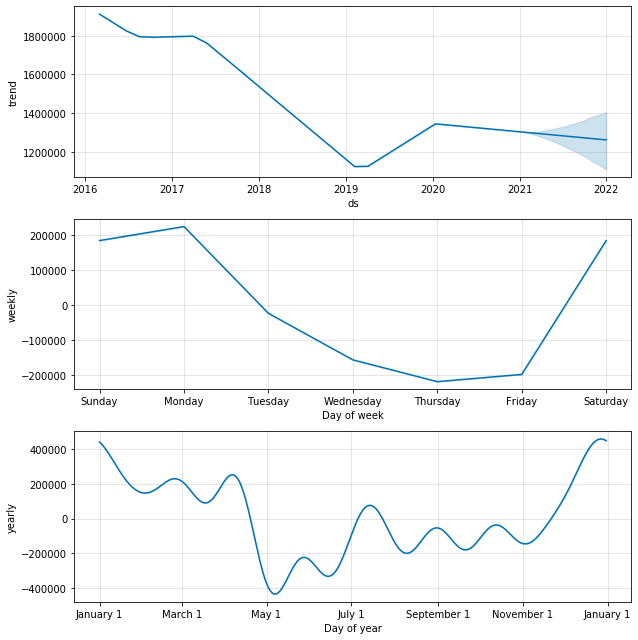

handle_time


,ds,yhat_lower,yhat,yhat_upper,handle_time,handle_time_forecast,error_prophet,error_forecast,diff
0,2021-01-04,1.684531e+06,1.944634e+06,2.186864e+06,1308354.0,3339378.0,636280.0,2031024.0,1394744.0
1,2021-01-05,1.449886e+06,1.686875e+06,1.959718e+06,1604377.0,2595929.0,82498.0,991552.0,909054.0
2,2021-01-06,1.281514e+06,1.542970e+06,1.785919e+06,1349627.0,2404033.0,193343.0,1054406.0,861063.0
3,2021-01-07,1.188251e+06,1.468935e+06,1.718149e+06,1439905.0,2323631.0,29030.0,883726.0,854696.0
4,2021-01-08,1.213705e+06,1.477110e+06,1.727930e+06,1520714.0,2340892.0,43604.0,820178.0,776574.0
5,2021-01-11,1.612073e+06,1.859197e+06,2.130328e+06,1532409.0,4522367.0,326788.0,2989958.0,2663170.0
6,2021-01-12,1.363876e+06,1.598743e+06,1.850103e+06,1607269.0,3606475.0,8526.0,1999206.0,1990680.0
7,2021-01-13,1.183390e+06,1.452945e+06,1.695574e+06,1590106.0,3271216.0,137161.0,1681110.0,1543949.0
8,2021-01-14,1.139241e+06,1.377786e+06,1.629801e+06,1554137.0,3141571.0,176351.0,1587434.0,1411083.0
9,2021-01-15,1.135128e+06,1.385568e+06,1.645808e+06,1420329.0,3191053.0,34761.0,1770724.0,1735963.0


In [720]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error
import datetime

def load_data(path):
    """
    using a path to a bu dataset return the dataframe
    """
    # create a pandas dataframe object
    df = pd.read_csv('../data/'+path, index_col=0,
                     parse_dates=['date'])

    # create column for aht
    df['aht'] = df['handle_time']/df['volume']
    df['aht_forecast'] = df['handle_time_forecast']/df['volume_forecast']


    df.index = df['date']
    return df

def remove_holidays(df, path='../data/holidays.csv'):
    """
    take in a holidays csv of dates and return
    a filtered dataframe
    """
    
    holidays = pd.read_csv(path)
    
    if 'ds' not in df.columns:
        date_marker = 'date'
    else:
        date_marker = 'ds'
    
    return df[(~df[date_marker].dt.weekday.isin([5,6])) & (~df[date_marker].isin(holidays.iloc[:,0].tolist()))]

def clean_training_data(df, holidays=False):
    """
    take in a dataframe and return a filtered dataframe
    """
    
    # remove holidays and weekends
    if not holidays:
        df = remove_holidays(df)
    
    ## remove zeros
    df = df[df['handle_time'] > 10000]
    
    # remove nulls
    df = df[df['aht'].notnull()]

    return df

def create_training_data(df, metric, start='2016-01-01', end='2020-06-01'):
    """
    takes in a dataframe and returns a filtered dataframe
    """
    
    df = df[(df['date'] >= start) & (df['date'] < end)]
    
    df = df[[metric]]
    df = df.reset_index()
    df.columns = ['ds', 'y']
    return df

def train_model(df):
    """
    takes in a dataframe with 2 cols
    'ds' and 'y' and returns a prediction
    """
    # create default prophet model
    m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
    m.fit(df)
    
    return m


def get_validation_data(df, end_training='2020-11-01', end_testing='2021-01-18'):
    """
    take in a dataframe and return a dataframe filtered after the end of training
    """
    df = remove_holidays(df)
    
    df = df[(df['date'] > end_training) & (df['date'] < end_testing)]
    
    return df



def get_accuracy(df2,forecast, kpi='handle_time'):
    """
    take in 2 dataframes df2 with original predictions and forecast with
    new predictions and return a dataframe of the MAE for each model and
    the difference between old model and prophet
    negative values indicate old model has less error.
    """
    mae1 = mean_absolute_error(df2[kpi], df2[kpi+'_forecast'])
    mae2 = mean_absolute_error(df2[kpi], forecast['yhat'])
    diff = mae1- mae2
    return pd.DataFrame(index=['old model', 'prophet', 'difference'], 
                 data=[int(mae1), int(mae2), int(diff)],
                 columns=['MAE'])

def get_performance(data, fields, start, end):
    """
    take in data as a list of csv from each business unit
    fields are the kpis being predicted
    start and end is the start date and end date of testing
    
    TODO
        setup model diagnostics
        https://facebook.github.io/prophet/docs/diagnostics.html
    """
    
    # load a dictionary with dates for starting training
    date_dict = {'BRO-Complex_aht_vol.csv':'2018-10-01', 'BRO_aht_vol.csv': '2018-11-01', 
    'CS-Alaska_aht_vol.csv':'2016-01-01', 'CS-John-Hancock_aht_vol.csv':'2019-12-01', 
    'CS-Maryland_aht_vol.csv': '2017-11-01', 'CS-National_aht_vol.csv':'2016-11-01', 
    'PSG_aht_vol.csv':'2019-11-01', 'RCS-PHONES_aht_vol.csv':'2018-11-01', 
    'RIS_aht_vol.csv':'2019-11-01', 'WISE-Contractual_aht_vol.csv':'2016-11-01'}
    
    for b in data:
        # create a list for the scores of each kpi
        a = []
        print('*'*80)
        print(b)
        print('*'*80)
        for k in fields:
            bu = b
            kpi = k
            start_train = '2016-03-01' #date_dict[b]
            start_test = start
            end_test = end

            df = load_data(bu)

            df = clean_training_data(df)
            
            df2 = get_validation_data(df, end_training=start_test)

            df = create_training_data(df, kpi, start=start_train, end=start_test)

            m = train_model(df)

            future = m.make_future_dataframe(periods=365)
            future = remove_holidays(future)
            forecast = m.predict(future)
            
            fig1 = m.plot(forecast)
            plt.title(k)
            fig2 = m.plot_components(forecast)
            plt.show()

            f = forecast[(forecast['ds'] > start_test) & (forecast['ds'] < end_test)]
            
            f = f.reset_index(drop=True)
            df2 = df2.reset_index(drop=True)

            write_f = f[['ds','yhat_lower', 'yhat', 'yhat_upper']]
            
            write_f = pd.concat([write_f, df2[[k,k+'_forecast']]], 1)
            write_f['error_prophet'] = (write_f['yhat'] - write_f[k]).abs().round()
            write_f['error_forecast'] = (write_f[k+'_forecast'] - write_f[k]).abs().round()
            write_f['diff'] = write_f['error_forecast'] - write_f['error_prophet']
            
            write_f.to_csv('../preds/'+k+'_'+b[:6]+'.csv')
            
            print(k)
            display(write_f)

            accuracy = get_accuracy(df2, f, kpi=kpi)
            a.append(accuracy)

        diff = pd.concat([a[0], a[1], a[2]], axis=1)
        diff.columns = ['volume', 'aht', 'handle_time']
        return m, diff

data = ['BRO_aht_vol.csv',
 'WISE-Contractual_aht_vol.csv',
 'CS-National_aht_vol.csv',
 'CS-Alaska_aht_vol.csv',
 'RIS_aht_vol.csv',
 'PSG_aht_vol.csv',
 'BRO-Complex_aht_vol.csv',
 'RCS-PHONES_aht_vol.csv',
 'CS-Maryland_aht_vol.csv',
 'CS-John-Hancock_aht_vol.csv']

data = ['RIS_aht_vol.csv']
m, diff = get_performance(data, ['volume', 'aht','handle_time'], '2021-01-01', '2021-01-18')

In [721]:
# run method for any business unit, kpi, and start and end date of testing
# get_performance(['WISE-Contractual_aht_vol.csv'], ['volume', 'aht','handle_time'], '2021-01-01', '2021-01-18')

# Workload and AHT see the largest difference in forecast accuracy on the metric Mean Absolute Error (MAE) when comparing the old model to prophet.

The new Prophet model workload forecasts for RIS (MAE ~ 46 hours) compared to Old Model (MAE ~ 439 hours) have been closer to the actual handle times recieved by an average of 393 hours daily for the period of January 1st to January 18th, 2021.